In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import KFold

In [27]:
# Preprocessing
def load_and_preprocess_images(dataset_path, image_size=(32, 32)):
    images = []
    labels = []
    label_map = {}
    for idx, animal in enumerate(os.listdir(dataset_path)):
        label_map[idx] = animal
        animal_path = os.path.join(dataset_path, animal)
        for img_filename in tqdm(os.listdir(animal_path), desc=f"Loading {animal}"):
            img_path = os.path.join(animal_path, img_filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

In [28]:
# Calculate distances
def calculate_distances(test_img, train_images, distance_metric='l1'):
    if distance_metric == 'l1':
        return np.sum(np.abs(train_images - test_img), axis=(1, 2))
    else:
        return np.sqrt(np.sum((train_images - test_img) ** 2, axis=(1, 2)))

In [29]:
# Predictions
def get_predictions(train_images, train_labels, test_images, k, distance_metric='l1'):
    predictions = []
    for test_img in tqdm(test_images, desc="Predicting"):
        distances = calculate_distances(test_img, train_images, distance_metric)
        nearest_neighbors_ids = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_neighbors_ids]
        unique, counts = np.unique(nearest_labels, return_counts=True)
        predictions.append(unique[np.argmax(counts)])
    return predictions

In [19]:
# Calculate accuracy
def calculate_accuracy(predictions, true_labels):
    return np.mean(predictions == true_labels)

In [20]:
# Plotting function
def plot_accuracies(k_values, accuracies_l1, accuracies_l2):
    plt.figure(figsize=(14, 8))
    plt.plot(k_values, accuracies_l1, marker='o', linestyle='-', color='b', label='Manhattan (L1)')
    plt.plot(k_values, accuracies_l2, marker='o', linestyle='-', color='g', label='Euclidean (L2)')
    plt.title('Cross-Validation Accuracy')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [21]:
# Top 5 predictions
def display_predictions(test_images, predictions, true_labels, label_map, num_to_display=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_to_display):
        plt.subplot(1, num_to_display, i + 1)
        plt.imshow(test_images[i], cmap='gray')
        plt.title(f'Predicted: {label_map[predictions[i]]}\nActual: {label_map[true_labels[i]]}')
        plt.axis('off')
    plt.show()

Predicting: 100%|████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 800.57it/s]


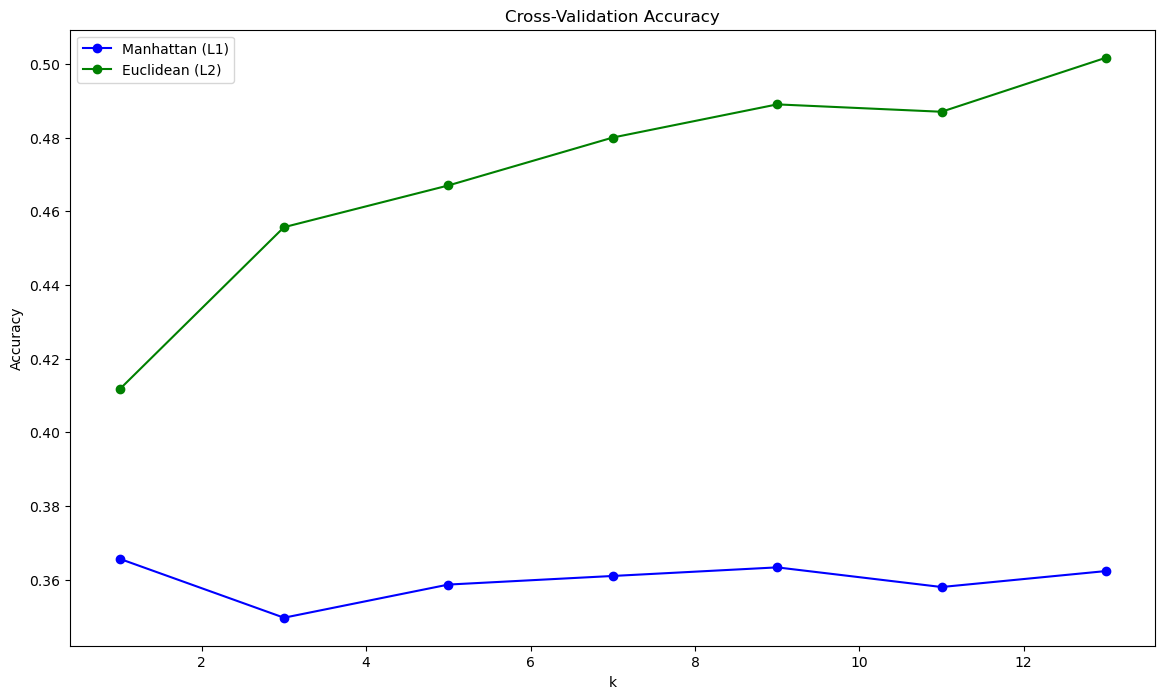

In [30]:
dataset_path = "/home/nemo/Coding/CVPR/animal_dataset/animals/animals"
images, labels, label_map = load_and_preprocess_images(dataset_path)

k_values = [1, 3, 5, 7, 9, 11, 13]
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

accuracies_l1 = {k: [] for k in k_values}
accuracies_l2 = {k: [] for k in k_values}

for train_index, test_index in kf.split(images):
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    
    for k in k_values:
        # L1 distance predictions
        predictions_l1 = get_predictions(train_images, train_labels, test_images, k, 'l1')
        accuracy_l1 = calculate_accuracy(predictions_l1, test_labels)
        accuracies_l1[k].append(accuracy_l1)
        
        # L2 distance predictions
        predictions_l2 = get_predictions(train_images, train_labels, test_images, k, 'l2')
        accuracy_l2 = calculate_accuracy(predictions_l2, test_labels)
        accuracies_l2[k].append(accuracy_l2)

mean_accuracies_l1 = [np.mean(accuracies_l1[k]) for k in k_values]
mean_accuracies_l2 = [np.mean(accuracies_l2[k]) for k in k_values]

plot_accuracies(k_values, mean_accuracies_l1, mean_accuracies_l2)

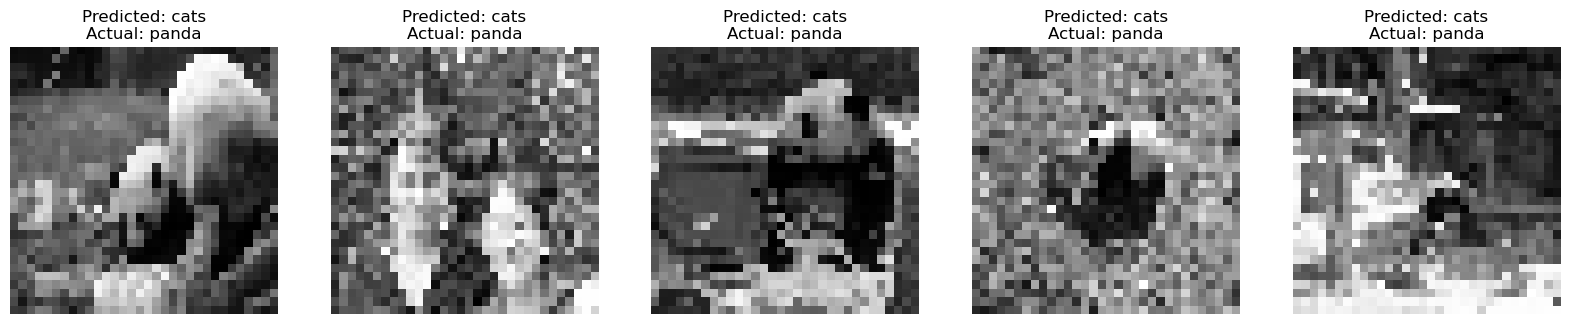

In [31]:
# Top 5 predictions
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f'Predicted: {label_map[predictions_l1[i]]}\nActual: {label_map[test_labels[i]]}')
    plt.axis('off')
plt.show()

### Discussion

This code implements a K-Nearest Neighbors (KNN) classification approach to predict animal classes from grayscale images. The system tests two distance metrics, Manhattan (L1) and Euclidean (L2), across multiple values of \(k\) using cross-validation.

#### 1. Data Preprocessing
Images are resized to 32x32 and converted to grayscale to simplify computation. The labels are assigned to each image according to its folder (representing different animals).

#### 2. Distance Calculation
The code supports two distance metrics: Manhattan (L1) and Euclidean (L2). The choice of metric impacts the classification performance, as shown in the cross-validation results.

#### 3. Cross-Validation
Using KFold cross-validation, the dataset is split into training and testing sets for evaluation. For each fold, predictions are generated using both distance metrics across varying \(k\) values (number of nearest neighbors). This helps assess the model's generalization.

#### 4. Results
The plot showing accuracy for different \(k\) values highlights the effectiveness of L1 and L2. For this dataset, the Manhattan (L1) distance metric provides better accuracy compared to Euclidean (L2). Generally, accuracy may improve up to a certain \(k\) value but then decrease if too many neighbors are considered, as irrelevant neighbors can dilute the result.

#### 5. Visualization
The final step visualizes the top five test images alongside their predicted and actual labels. This provides a qualitative understanding of the classifier's performance.


For this particular dataset, the Euclidean (L1) method results in better accuracy.
